<a href="https://colab.research.google.com/github/Achuna/Climate-Data-UMBC-Summer-Research/blob/master/Notebooks/2020/Granger_Causality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#GAMs & Granger Causality

In this causality approach, I will use generalized additive models to compute the regression functions of different relationships and later compute the F score in an attempt to reject the null hypothesis and discover granger causation.

**Granger Causality**

Granger causality is a way to investigate causality between two variables in a time series. The method is a probabilistic account of causality; it uses empirical data sets to find. With granger causality, **you aren’t testing a true cause-and-effect relationship**; What you want to know is if a particular variable comes before another in the time series.

**Generalized Additive Models**

Generalized Additive Models (GAMs) are essentially an extension of generalized linear models (GLM), those of which consist of three main components: the linear predictor, probability distribution, and a link function which converts the expected value to scale with the linear predictor. GAMs are more flexible than GLM and do not necessarily have to be linear. GAMs consists of a sum of smoothing functions which aims to capture patterns in the data. Backfitting is used to fit the GAM with the data by iteratively smoothing partial residuals and adjusting coefficients. Several smoothing techniques can be used to accomplish this.


#Walkthrough

The next few sections will show step by step my approach to discovering Granger causality using generalized additive models

##Data Preperation

In [1]:
import pandas as pd
import dask.dataframe as dd #for parallel processing
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import glob

#Takes in a 1D array and makes subsets of the array, returning a matrix
#Chunk size - how big each subset of the array will be
#numFiles - defines the columns
def getMatrix(array, chunkSize, numFiles):
  low = 0
  matrix = []
  for i in range(0, numFiles):
    matrix.append(array[low:low+chunkSize])
    low = low + chunkSize
  return np.transpose(matrix)


files.upload() #Upload Files from local directory

filelist = glob.glob('eof_ts*') #get all files starting with eof

print(filelist)

#reading in files
df = dd.read_csv(filelist, names=["Initial"]) #use parallel processing to read in all the files (much faster)
df = df.compute() #create dataframe

#Dask reads in all the data into a 2D array, storing all the values in their own 1D arrays. Ex. [ [21], [23], [59] ....]
#Here I am extracting the data and putting it all in a 1D array
temp = df.values
array = []
for i in range(0, len(temp)):
  array.append(temp[i][0])
  
#set the column names  
columnNames = [filename[filename.rfind('_')+1 : len(filename)] for filename in filelist]

#To reconstruct he matrix in our desired way, call the getMatrix function  
matrix = getMatrix(array, 480, len(filelist)) #480 because we are looking at 480 months ~40 yrs

df = pd.DataFrame(matrix, columns = columnNames) #assign matrix to the dataframe

df #print dataframe


Saving eof_ts_msl-01 to eof_ts_msl-01
Saving eof_ts_si10-00 to eof_ts_si10-00
Saving eof_ts_sst-00 to eof_ts_sst-00
Saving eof_ts_t2m-02 to eof_ts_t2m-02
['eof_ts_t2m-02', 'eof_ts_msl-01', 'eof_ts_sst-00', 'eof_ts_si10-00']


,t2m-02,msl-01,sst-00,si10-00
0,1.923936,-0.499200,-0.034950,-0.061642
1,1.090690,-0.359078,-0.112926,0.271446
2,1.509008,-1.042020,-0.120599,0.903523
3,2.307873,-0.844485,0.072819,0.714178
4,1.432568,-0.972610,-0.009774,0.846069
...,...,...,...,...
475,-1.716517,0.577803,0.946698,-0.276251
476,-2.854198,-0.750976,1.027206,0.418820
477,-2.510073,0.157638,1.263357,0.090285
478,-2.666805,-0.763912,1.282465,0.958832


##Time Lag

When testing for causality, we want to see if lagged variables (or variables in the past) have a role in improving the predictive power of the response variable. Here we apply a lag of 4 months to each variable. We do this by shifting the colum down a fixed amount and removing the empty rows

In [21]:
#takes columns and shift it downwards with lag = n, creating a new column. Aftwards it deletes rows containing NaN
def timeLag(dataframe, variables = [], maxLag = 4): #lag in months*
  
  data = dataframe.copy() #make a copy of dataframe
  for variable in variables:
    
    columnData = pd.DataFrame(dataframe[variable]) #look at the column we want to shift

    tempLag = columnData.shift(maxLag)

    newCol = pd.DataFrame(tempLag)

    newName = variable+"_L" #label 'L' for lagged variable
    data[newName] = newCol

  data = data.dropna() #drop the rows with NaN
  data.index = np.arange(0, len(data)) #fix the indexing after shifting
  return data

###Functions for retrieving lag information###

def getLag(string):
  if "_" in string:
    return str(string[string.rfind('_')+1 : len(string)])
  else:
    return str(0)
  
def withoutLag(string):
  if "_" in string:
    return str(string[0: string.rfind('_')])
  
def getLocation(string):
  if '_' in string:
    return str(string[string.rfind('-')+1 : string.rfind('_')])
  else:
    return str(string[string.rfind('-')+1 : len(string)])

#Use to rename new colums when lag is applied
def renameColumn(column, appendString):
  return column +"_"+ appendString

lagData = timeLag(df, df.columns, 4)
lagData

,t2m-02,msl-01,sst-00,si10-00,t2m-02_L,msl-01_L,sst-00_L,si10-00_L
0,1.432568,-0.972610,-0.009774,0.846069,1.923936,-0.499200,-0.034950,-0.061642
1,0.912408,-1.497780,0.123207,0.729229,1.090690,-0.359078,-0.112926,0.271446
2,0.115253,-2.333303,-0.020594,1.790234,1.509008,-1.042020,-0.120599,0.903523
3,1.089567,-0.509094,0.131408,1.780666,2.307873,-0.844485,0.072819,0.714178
4,1.420504,-0.641116,0.250609,0.902878,1.432568,-0.972610,-0.009774,0.846069
...,...,...,...,...,...,...,...,...
471,-1.716517,0.577803,0.946698,-0.276251,-1.800670,0.819801,0.710448,-1.321030
472,-2.854198,-0.750976,1.027206,0.418820,-1.824383,0.259479,0.909621,-0.562471
473,-2.510073,0.157638,1.263357,0.090285,-1.766306,0.501073,0.941405,-0.532906
474,-2.666805,-0.763912,1.282465,0.958832,-2.012271,0.020921,0.940579,-0.544551


##Visualize Data

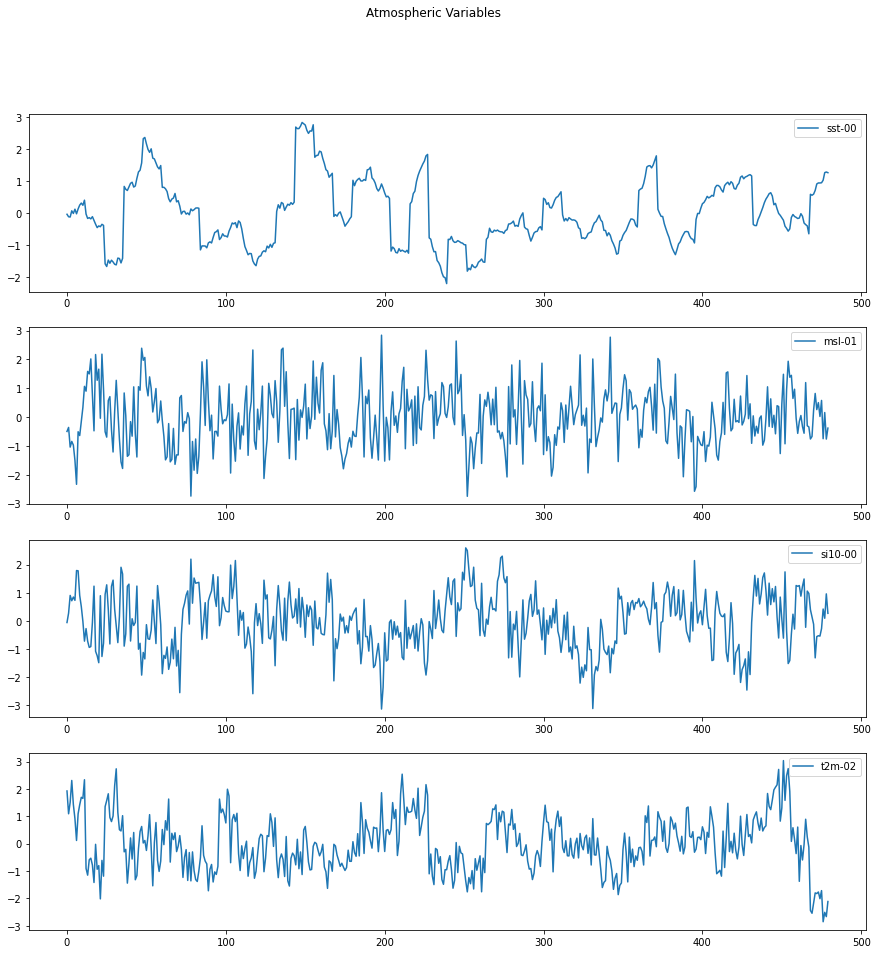

In [85]:
fig, axs = plt.subplots(len(df.columns))

fig.suptitle('Atmospheric Variables')

fig.set_figheight(15)
fig.set_figwidth(15)

for i, ax in enumerate(axs):
    df[df.columns[i]].plot(ax=axs[i], legend=True)

In [ ]:
# fig, axs = plt.subplots(len(lagData.columns))

# fig.set_figheight(15)
# fig.set_figwidth(15)


# for i, ax in enumerate(axs):
#     lagData[lagData.columns[i]].plot(ax=axs[i], legend=True)


##Causality

In this example, I will focus on one relationship to discover granger causality

**Approach**


1) I'm using some data from last summer (as a starting point) and applied a fixed lag of 4 months on each variable by shifting the column down one step:


2) I select one unlagged variable to use as my response variable (y). I use pyGAM to fit the GAM using a lagged time series of that response variable (functioning as explanatory variables) (X1). ex. gam.fit(X1, y)


3) After learning the model, with all its smooth functions and corresponding coefficients, I ADD a second lagged explanatory variable (X2) and create a second GAM. ex. gam.fit(X2, y)


4) Afterwards, I store the model predictions of X1 and X2 and calculate the mean squared error of both predictions. I use these values in my F-test to output a p-value in order to reject null-hypothesis “X2 does not granger cause y” (given that the p value < 0.05 (significance level) ). Since I am trying to find if adding a new variable, X2, improves the predictive power of the response variable. 


5) I repeat the steps above with different combinations of response and explanatory variables to discover granger causality (NOT 'true cause', just to show if a variable shows precedence on another)




In [14]:
!pip install pygam

     |████████████████████████████████| 1.8MB 3.4MB/s 


Here we specify the the response variable and 2 sets of explanatory variables X1 and X2

X1 being a set of lagged versions of the response variable

X2 being the same as X1 with an additional lagged variable added

In [22]:
from pygam import LinearGAM

#Using lagged versions of the response variable as explanatory variables
t_self = timeLag(df, ['sst-00'], 4)
X1 = (t_self.drop(df.columns, axis=1)).values

# #Adding an aditional variable 
t_new = timeLag(df, ['sst-00','t2m-02'], 4)
X2 = (t_new.drop(df.columns, axis=1)).values

y = t_self['sst-00'] #response variable


# print(X1)
# print(X2)


Now, we use pyGAM to fit the data using the Linear GAM class. To save us time guessing the smoothing penalty, we will use pyGAM's built-in gridsearch function which utilizes generalized cross validation and  

Note: there are other options when fiting the data

In [28]:
#LinearGAM uses a normal distribution with an identity link function
from pygam import GAM, s, f, LinearGAM

# n_splines = refers to the number of splines to use in each of the smooth function that is going to be fitted.
# lam = is the penalization term that is multiplied to the second derivative in the overall objective function.

#the more splines the more flexible and wiggly the model is
#lam = smoothing penalty

gamModel1 = LinearGAM(n_splines=50).gridsearch(X1, y) #Learned GAM with first explanatory variable
gamModel2 = LinearGAM(n_splines=50).gridsearch(X2, y) #Learned GAM with additional explanatory variable added

#View model summary
gamModel1.summary()
gamModel2.summary()

# print(gamModel2.statistics_['p_values'])


#Plot partial dependence
#df['sst-00'].plot(legend=True) #actual values

# XX = gamModel2.generate_X_grid(term=0)

# plt.plot(XX, gamModel2.predict(XX), 'r--') #GAM

# # here we define a 95% prediction interval (in blue)
# plt.plot(XX, gamModel2.prediction_intervals(XX, width=.95), color='b', ls='--')

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      7.7831
Link Function:                     IdentityLink Log Likelihood:                                  -589.2055
Number of Samples:                          476 AIC:                                             1195.9771
                                                AICc:                                            1196.3458
                                                GCV:                                                0.4027
                                                Scale:                                              0.3909
                                                Pseudo R-Squared:                                   0.6179
Feature Function                  Lam

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  from ipykernel import kernelapp as app


Store predictions in their own variables. these will be our estimated response values

Now calculate the mean squared error

https://www.statisticshowto.com/mean-squared-error/

1. Find the regression line.

2. Insert your X values into the linear regression equation to find the new Y values (Y’).

3. Subtract the new Y value from the original to get the error.

4. Square the errors.

5. Add up the errors.

6. Find the mean.

In [90]:
# are the estimated y values of both models
modelPred1 = gamModel1.predict(X1)
modelPred2 = gamModel2.predict(X2)

#Calculate and store the mean squared error
mse1 = np.mean((modelPred1 - y)**2)
mse2 = np.mean((modelPred2 - y)**2)

print(mse1)
print(mse2)

0.38449838893124394
0.3840622340075368


In [132]:
#SAME AS ABOVE
#This is how tht MSE is calculated but more in depth

# summation = 0  #variable to store the summation of differences
# n = len(y) #finding total number of items in list
# for i in range (0,n):  #looping through each element of the list
#   difference = y[i] - modelPred1[i]  #finding the difference between observed and predicted value
#   squared_difference = difference**2  #taking square of the differene 
#   summation = summation + squared_difference  #taking a sum of all the differences
# MSE = summation/n  #dividing summation by total values to obtain average
# print(MSE)

Now we use the mean square error to calculate the f score and p value

In [91]:
from sklearn.metrics import mean_squared_error
import scipy

maxlag = 4 
n = df.shape[0]
k = 2


f_score = ((mse1-mse2)/mse2)*((n-k*maxlag)/maxlag)
print('f score: ', f_score)
p_value = scipy.stats.f.sf(f_score, maxlag, n-k*maxlag)
print("p_value: ", p_value)

f score:  0.13400505553595174
p_value:  0.969815915979183


We test if the p value is less than the alpha value. If so, we reject the null hypothesis, otherwise the null hypothesis holds true

In [82]:
alpha = 0.05

if p_value < alpha:
  print("Null hypothesis is rejected. X2 granger causes X1")
else:
  print("Null hypothesis holds. X2 does NOT granger causes X1")

Null hypothesis holds. X2 does not granger causes X1


#Discovering Granger Causality 

Here we will bring all the steps previously defined in the walkthrough and make it more modular. I will loop through different cause-effect pairs to find any granger causes. After doing so, it will output a graph alongside all the causal links

In [1]:
!pip install pygam
!pip install graphviz

     |████████████████████████████████| 1.8MB 2.7MB/s 


Preparing the Data

In [2]:
import pandas as pd
import dask.dataframe as dd #for parallel processing
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import glob

#Takes in a 1D array and makes subsets of the array, returning a matrix
#Chunk size - how big each subset of the array will be
#numFiles - defines the columns
def getMatrix(array, chunkSize, numFiles):
  low = 0
  matrix = []
  for i in range(0, numFiles):
    matrix.append(array[low:low+chunkSize])
    low = low + chunkSize
  return np.transpose(matrix)


files.upload() #Upload Files from local directory
filelist = glob.glob('eof_ts*') #get all files starting with eof
print(filelist)

#reading in files
df = dd.read_csv(filelist, names=["Initial"]) #use parallel processing to read in all the files (much faster)
df = df.compute() #create dataframe

#Dask reads in all the data into a 2D array, storing all the values in their own 1D arrays. Ex. [ [21], [23], [59] ....]
#Here I am extracting the data and putting it all in a 1D array
temp = df.values
array = []
for i in range(0, len(temp)):
  array.append(temp[i][0])
  
#set the column names  
columnNames = [filename[filename.rfind('_')+1 : len(filename)] for filename in filelist]

#To reconstruct he matrix in our desired way, call the getMatrix function  
matrix = getMatrix(array, 480, len(filelist)) #480 because we are looking at 480 months ~40 yrs

df = pd.DataFrame(matrix, columns = columnNames) #assign matrix to the dataframe

df #print dataframe

Saving eof_ts_msl-01 to eof_ts_msl-01
Saving eof_ts_si10-00 to eof_ts_si10-00
Saving eof_ts_sst-00 to eof_ts_sst-00
Saving eof_ts_t2m-02 to eof_ts_t2m-02
['eof_ts_t2m-02', 'eof_ts_msl-01', 'eof_ts_sst-00', 'eof_ts_si10-00']


,t2m-02,msl-01,sst-00,si10-00
0,1.923936,-0.499200,-0.034950,-0.061642
1,1.090690,-0.359078,-0.112926,0.271446
2,1.509008,-1.042020,-0.120599,0.903523
3,2.307873,-0.844485,0.072819,0.714178
4,1.432568,-0.972610,-0.009774,0.846069
...,...,...,...,...
475,-1.716517,0.577803,0.946698,-0.276251
476,-2.854198,-0.750976,1.027206,0.418820
477,-2.510073,0.157638,1.263357,0.090285
478,-2.666805,-0.763912,1.282465,0.958832


In [7]:
from pygam import LinearGAM
from graphviz import Digraph
from sklearn.metrics import mean_squared_error
import scipy

#takes columns and shift it downwards with lag = n, creating a new column. Aftwards it deletes rows containing NaN
def timeLag(dataframe, variables = [], maxLag = 4): #lag in months*
  data = dataframe.copy() #make a copy of dataframe
  for variable in variables:
    columnData = pd.DataFrame(dataframe[variable]) #look at the column we want to shift
    tempLag = columnData.shift(maxLag)
    newCol = pd.DataFrame(tempLag)
    newName = variable+"_L" #label 'L' for lagged variable
    data[newName] = newCol
  data = data.dropna() #drop the rows with NaN
  data.index = np.arange(0, len(data)) #fix the indexing after shifting
  return data


####INPUTS####
# Dataframe object
# Max time lag applied variable
# n_splines: function estimates used for GAMs. the more splines the more flexible and wiggly the models are
# alpha: significance value to compare with p value
###OUTPUTS###
#Summary of discovered granger causes#
#list of tuples containing causal pairs
#Digraph showing causal
def granger_causal_gam(data, maxlag=4, splines=50, alpha=0.05):
  columnNames = data.columns

  n = df.shape[0]
  k = 2 #amount of feature groups we are addressing
  links = []

  for col1 in columnNames:
    for col2 in columnNames:
      print("\n================================================================================================\n")
      print("Testing {} can granger cause {}, with lag: {}\n".format(col1, col2, maxlag))

      #Using lagged versions of the response variable as explanatory variables
      t_self = timeLag(data, [col2], maxlag)
      X1 = (t_self.drop(data.columns, axis=1)).values

      # #Adding an aditional variable 
      t_new = timeLag(data, [col2,col1], maxlag)
      X2 = (t_new.drop(data.columns, axis=1)).values

      y = t_self[col2] #response variable

      #Use generalized cross validation to find the best smoothing penalty to fit the GAM
      gamModel1 = LinearGAM(n_splines=splines).gridsearch(X1, y) #Learned GAM with first explanatory variable
      gamModel2 = LinearGAM(n_splines=splines).gridsearch(X2, y) #Learned GAM with additional explanatory variable added

      # XX = gamModel2.generate_X_grid(term=0)
      # plt.plot(XX, gamModel2.predict(XX), 'r--') #GAM

      # are the estimated y values of both models
      modelPred1 = gamModel1.predict(X1)
      modelPred2 = gamModel2.predict(X2)

      #Calculate and store the mean squared error
      mse1 = np.mean((modelPred1 - y)**2)
      mse2 = np.mean((modelPred2 - y)**2)

      print("\n\n---------------------------------------------------------Results:")
      print("\nMSE of predicted y: {}".format(mse1))
      print("MSE of predicted y w/ additional variable: {}".format(mse2))

      #Compute f_score and p value
      f_score = ((mse1-mse2)/mse2)*((n-k*maxlag)/maxlag)
      print('\nf score: ', f_score)
      p_value = scipy.stats.f.sf(f_score, maxlag, n-k*maxlag)
      print("p_value: ", p_value)

      if p_value < alpha:
        print("\nLag rejected H0. {} granger causes {}, with p value: {}".format(col1, col2, p_value))
        links.append((col1, col2)) #append to causal links
      else:
        print("\n{} does NOT granger causes {}, with p value: {}".format(col1, col2, p_value))

  g = Digraph('Granger Causal Graph', filename='causal graph') #name, filename
  g.attr(rankdir='LR', size='20,15')
  g.attr('node', shape='circle')

  g.edges(links)

  g.view()
  print(links)

  return (links, g)

results = granger_causal_gam(df)

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00



Testing t2m-02 can granger cause t2m-02, with lag: 4



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00



---------------------------------------------------------Results:

MSE of predicted y: 0.7786371840194636
MSE of predicted y w/ additional variable: 0.7786371840194636

f score:  0.0
p_value:  1.0

t2m-02 does NOT granger causes t2m-02, with p value: 1.0


Testing t2m-02 can granger cause msl-01, with lag: 4



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00



---------------------------------------------------------Results:

MSE of predicted y: 0.9612552288195104
MSE of predicted y w/ additional variable: 0.9397763555874542

f score:  2.6969257380372302
p_value:  0.030293297145649597

Lag rejected H0. t2m-02 granger causes msl-01, with p value: 0.030293297145649597


Testing t2m-02 can granger cause sst-00, with lag: 4



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00



---------------------------------------------------------Results:

MSE of predicted y: 0.38449838893124394
MSE of predicted y w/ additional variable: 0.3840622340075368

f score:  0.13400505553595174
p_value:  0.969815915979183

t2m-02 does NOT granger causes sst-00, with p value: 0.969815915979183


Testing t2m-02 can granger cause si10-00, with lag: 4



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00



---------------------------------------------------------Results:

MSE of predicted y: 0.8388993112944367
MSE of predicted y w/ additional variable: 0.8477962461880948

f score:  -1.2383144206783034
p_value:  1.0

t2m-02 does NOT granger causes si10-00, with p value: 1.0


Testing msl-01 can granger cause t2m-02, with lag: 4



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00



---------------------------------------------------------Results:

MSE of predicted y: 0.7786371840194636
MSE of predicted y w/ additional variable: 0.7520546479908992

f score:  4.1708927133823925
p_value:  0.0024931571035459133

Lag rejected H0. msl-01 granger causes t2m-02, with p value: 0.0024931571035459133


Testing msl-01 can granger cause msl-01, with lag: 4



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00



---------------------------------------------------------Results:

MSE of predicted y: 0.9612552288195104
MSE of predicted y w/ additional variable: 0.9612552288195104

f score:  0.0
p_value:  1.0

msl-01 does NOT granger causes msl-01, with p value: 1.0


Testing msl-01 can granger cause sst-00, with lag: 4



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00



---------------------------------------------------------Results:

MSE of predicted y: 0.38449838893124394
MSE of predicted y w/ additional variable: 0.386897309669412

f score:  -0.7316480110593283
p_value:  1.0

msl-01 does NOT granger causes sst-00, with p value: 1.0


Testing msl-01 can granger cause si10-00, with lag: 4



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00



---------------------------------------------------------Results:

MSE of predicted y: 0.8388993112944367
MSE of predicted y w/ additional variable: 0.8007484411513358

f score:  5.621993681827349
p_value:  0.0001990462960982326

Lag rejected H0. msl-01 granger causes si10-00, with p value: 0.0001990462960982326


Testing sst-00 can granger cause t2m-02, with lag: 4



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00



---------------------------------------------------------Results:

MSE of predicted y: 0.7786371840194636
MSE of predicted y w/ additional variable: 0.7672136948574657

f score:  1.7569703593027977
p_value:  0.13637414463775036

sst-00 does NOT granger causes t2m-02, with p value: 0.13637414463775036


Testing sst-00 can granger cause msl-01, with lag: 4



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00



---------------------------------------------------------Results:

MSE of predicted y: 0.9612552288195104
MSE of predicted y w/ additional variable: 0.9484217682103083

f score:  1.5967034948422307
p_value:  0.17400002737908793

sst-00 does NOT granger causes msl-01, with p value: 0.17400002737908793


Testing sst-00 can granger cause sst-00, with lag: 4



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00



---------------------------------------------------------Results:

MSE of predicted y: 0.38449838893124394
MSE of predicted y w/ additional variable: 0.38449838893124394

f score:  0.0
p_value:  1.0

sst-00 does NOT granger causes sst-00, with p value: 1.0


Testing sst-00 can granger cause si10-00, with lag: 4



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00



---------------------------------------------------------Results:

MSE of predicted y: 0.8388993112944367
MSE of predicted y w/ additional variable: 0.7592918858703108

f score:  12.37162726858288
p_value:  1.4127746009036933e-09

Lag rejected H0. sst-00 granger causes si10-00, with p value: 1.4127746009036933e-09


Testing si10-00 can granger cause t2m-02, with lag: 4



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00



---------------------------------------------------------Results:

MSE of predicted y: 0.7786371840194636
MSE of predicted y w/ additional variable: 0.7543954894953359

f score:  3.791804158002931
p_value:  0.004784618110324252

Lag rejected H0. si10-00 granger causes t2m-02, with p value: 0.004784618110324252


Testing si10-00 can granger cause msl-01, with lag: 4



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00



---------------------------------------------------------Results:

MSE of predicted y: 0.9612552288195104
MSE of predicted y w/ additional variable: 0.9421998591441944

f score:  2.3864720418549545
p_value:  0.050354691950955016

si10-00 does NOT granger causes msl-01, with p value: 0.050354691950955016


Testing si10-00 can granger cause sst-00, with lag: 4



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00



---------------------------------------------------------Results:

MSE of predicted y: 0.38449838893124394
MSE of predicted y w/ additional variable: 0.38026432264759147

f score:  1.3138750908641315
p_value:  0.2637841158467672

si10-00 does NOT granger causes sst-00, with p value: 0.2637841158467672


Testing si10-00 can granger cause si10-00, with lag: 4



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00




---------------------------------------------------------Results:

MSE of predicted y: 0.8388993112944367
MSE of predicted y w/ additional variable: 0.8388993112944367

f score:  0.0
p_value:  1.0

si10-00 does NOT granger causes si10-00, with p value: 1.0
[('t2m-02', 'msl-01'), ('msl-01', 't2m-02'), ('msl-01', 'si10-00'), ('sst-00', 'si10-00'), ('si10-00', 't2m-02')]


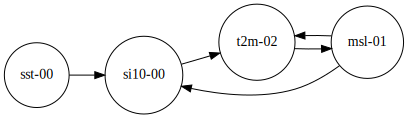

In [121]:
results[1] #show graph`